___MEMORY USAGE  BEFORE AND AFTER COMPLETION FOR TRAIN:___
<br/>
Memory usage before running this script : 1975.3707885742188  MB
<br/>
Memory usage after running this script  : ~ **480  MB**
<br/>
This is ~ 28 % of the initial size


___MEMORY USAGE  BEFORE AND AFTER COMPLETION FOR TEST:___
<br/>
Memory usage before running this script : 1693.867820739746  MB
<br/>
Memory usage after running this script: ~ **480  MB**
<br/>
This is ~  28  % of the initial size

## Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
gc.enable()
import time
import warnings
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")


## Import Dataset to play with it

In [26]:
%%time
# import Dataset to play with it
train_identity= pd.read_csv("ieee-fraud-detection/train_identity.csv")
train_transaction= pd.read_csv("ieee-fraud-detection/train_transaction.csv")
test_identity= pd.read_csv("ieee-fraud-detection/test_identity.csv")
test_transaction = pd.read_csv('ieee-fraud-detection/test_transaction.csv')
print ("Done!")

Done!
Wall time: 1min 10s


In [27]:
print('Shape of Data:')
print(train_transaction.shape)
print(test_transaction.shape)
print(train_identity.shape)
print(test_identity.shape)

Shape of Data:
(590540, 394)
(506691, 393)
(144233, 41)
(141907, 41)


### Creat our train & test dataset

In [28]:
# Creat our train & test dataset
#%%time
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

In [29]:
del train_identity,train_transaction,test_identity, test_transaction

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 435 entries, TransactionID_x to DeviceInfo
dtypes: float64(400), int64(4), object(31)
memory usage: 1.9+ GB


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 3663549 to 4170239
Columns: 432 entries, TransactionDT to DeviceInfo
dtypes: float64(399), int64(2), object(31)
memory usage: 1.7+ GB


# Reducing  Memory Size
It is necessary that after using this code, carefully check the output results for each column.

In [31]:
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            print("min for this col: ",mn)
            print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

Reducing for train data set:

In [32]:
train, NAlist = reduce_mem_usage(train)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 1959.8763732910156  MB
******************************
Column:  TransactionID_x
dtype before:  int64
min for this col:  2987000
max for this col:  3577539
dtype after:  uint32
******************************
******************************
Column:  isFraud
dtype before:  int64
min for this col:  0
max for this col:  1
dtype after:  uint8
******************************
******************************
Column:  TransactionDT
dtype before:  int64
min for this col:  86400
max for this col:  15811131
dtype after:  uint32
******************************
******************************
Column:  TransactionAmt
dtype before:  float64
min for this col:  0.251
max for this col:  31937.391
dtype after:  float32
******************************
******************************
Column:  card1
dtype before:  int64
min for this col:  1000
max for this col:  18396
dtype after:  uint16
******************************
******************************
Column:  card2
dtype befor

Reducing for test data set:

In [33]:
test, NAlist = reduce_mem_usage(test)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 1677.7336883544922  MB
******************************
Column:  TransactionID_x
dtype before:  int64
min for this col:  3663549
max for this col:  4170239
dtype after:  uint32
******************************
******************************
Column:  TransactionDT
dtype before:  int64
min for this col:  18403224
max for this col:  34214345
dtype after:  uint32
******************************
******************************
Column:  TransactionAmt
dtype before:  float64
min for this col:  0.018000000000000002
max for this col:  10270.0
dtype after:  float32
******************************
******************************
Column:  card1
dtype before:  int64
min for this col:  1001
max for this col:  18397
dtype after:  uint16
******************************
******************************
Column:  card2
dtype before:  float64
min for this col:  100.0
max for this col:  600.0
dtype after:  uint16
******************************
******************************
C

Check again! our RAM. 2 GB has got free!

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 2987000 to 3577539
Columns: 433 entries, isFraud to DeviceInfo
dtypes: float32(80), int16(7), int8(9), object(31), uint16(63), uint32(2), uint8(241)
memory usage: 568.5+ MB


In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 3663549 to 4170239
Columns: 432 entries, TransactionDT to DeviceInfo
dtypes: float32(80), int16(1), int8(9), object(31), uint16(50), uint32(2), uint8(259)
memory usage: 481.0+ MB


## Add this kernel as Dataset
Now we just save our output as csv files. then you can simply add them to your own kernel.you will save time and  memory.

In [56]:
train.to_csv('train.csv', index=False)

In [2]:
train_df = pd.read_csv("train.csv")

In [11]:
train_df.shape

(590540, 435)

In [60]:
# Explore Categorical features
print('Training set:')
for col_name in train_df.columns:
    if train_df[col_name].dtypes == 'object' :
        unique_cat = len(train_df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

print("****************")
    
print('Test set:')
for col_name in test_df.columns:
    if test_df[col_name].dtypes == 'object' :
        unique_cat = len(test_df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Training set:
Feature 'ProductCD' has 5 categories
Feature 'card4' has 5 categories
Feature 'card6' has 5 categories
Feature 'P_emaildomain' has 60 categories
Feature 'R_emaildomain' has 61 categories
Feature 'M1' has 3 categories
Feature 'M2' has 3 categories
Feature 'M3' has 3 categories
Feature 'M4' has 4 categories
Feature 'M5' has 3 categories
Feature 'M6' has 3 categories
Feature 'M7' has 3 categories
Feature 'M8' has 3 categories
Feature 'M9' has 3 categories
Feature 'id_12' has 3 categories
Feature 'id_15' has 4 categories
Feature 'id_16' has 3 categories
Feature 'id_23' has 4 categories
Feature 'id_27' has 3 categories
Feature 'id_28' has 3 categories
Feature 'id_29' has 3 categories
Feature 'id_30' has 76 categories
Feature 'id_31' has 131 categories
Feature 'id_33' has 261 categories
Feature 'id_34' has 5 categories
Feature 'id_35' has 3 categories
Feature 'id_36' has 3 categories
Feature 'id_37' has 3 categories
Feature 'id_38' has 3 categories
Feature 'DeviceType' has 3 ca

Count Plot for Fraudulent vs legitimate transaction


0    96.500999
1     3.499001
Name: isFraud, dtype: float64

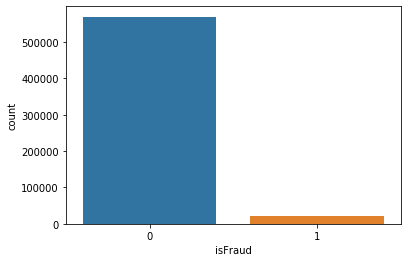

In [41]:
# Visualize target variable.(isFraud)
sns.countplot(train_df['isFraud'])
print("Count Plot for Fraudulent vs legitimate transaction") ## Imbalanced Dataset
train_df['isFraud'].value_counts(normalize=True) * 100

In [4]:
perc_fraud = len(train_df[train_df['isFraud']==1].index)*100/train_df.shape[0]
print("Percentage of Fradaulent records in dataset {:.2f}".format(perc_fraud) )

Percentage of Fradaulent records in dataset 3.50


In [5]:
# Check missing data - Many Columns have more than 50% NA/Null records
def missing_data(df) :
    count = df.isnull().sum()
    percent = (df.isnull().sum()) / (df.isnull().count()) * 100
    total = pd.concat([count, percent], axis=1, keys = ['Count', 'Percent'])
    types = []
    for col in df.columns :
        dtypes = str(df[col].dtype)
        types.append(dtypes)
    total['dtypes'] = types
    
    return np.transpose(total)

missing_data(train_df)

,TransactionID_x,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
Count,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dtypes,int64,int64,int64,float64,object,int64,int64,int64,object,int64,...,object,int64,object,object,object,object,object,object,object,object


In [3]:
#Fill missing values

train_df = train_df.fillna(-999)

In [4]:
missing_data(train_df)

NameError: name 'missing_data' is not defined

(472432, 435) (472432,)
(118108, 435) (118108,)


In [6]:
train_y = train_df['isFraud']
train_X = train_df.drop('isFraud', axis=1)

In [7]:
for f in train_X.columns:
    #if train_X[f].dtype=='object' or test_df[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_X[f].values))
        train_X[f] = lbl.transform(list(train_X[f].values))

In [8]:
#Split train into 80/20 for test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(472432, 434) (472432,)
(118108, 434) (118108,)


In [17]:
#Logistic Regression Model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
logreg.predict_proba(X_test)

array([[0.99256002, 0.00743998],
       [0.99482108, 0.00517892],
       [0.98702866, 0.01297134],
       ...,
       [0.99406373, 0.00593627],
       [0.99615111, 0.00384889],
       [0.99189613, 0.00810387]])

In [20]:
logreg.score(X_test, y_test)

0.9677498560639415

In [22]:
#Random Forest Model
forest = RandomForestClassifier(n_estimators=30)

forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
forest.predict_proba(X_test)

array([[0.8, 0.2],
       [1. , 0. ],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

In [33]:
forest.score(X_test, y_test)

0.9806871676770413

In [25]:
forest.score(X_train, y_train)

0.9992824364141294

In [18]:
#Decision Tree Model
from sklearn import tree

dec_tree = tree.DecisionTreeClassifier()

dec_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [19]:
dec_tree.predict_proba(X_test)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [20]:
dec_tree.score(X_test, y_test)

0.967580519524503

In [21]:
dec_tree.score(X_train, y_train)

1.0

In [13]:
#Extra Trees Model
from sklearn.ensemble import ExtraTreesClassifier

extra_trees = ExtraTreesClassifier(n_estimators=100, random_state=0)
extra_trees.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=0, verbose=0,
                     warm_start=False)

In [14]:
extra_trees.predict_proba(X_test)

array([[0.9, 0.1],
       [1. , 0. ],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

In [15]:
extra_trees.score(X_test, y_test)

0.9806956345040133

In [17]:
extra_trees.score(X_train, y_train)

1.0

In [9]:
#Linear Regression Model
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)

In [42]:
reg.predict(X_test)

array([ 0.0588252 ,  0.02646262, -0.01498264, ...,  0.04314496,
       -0.0234111 ,  0.02011509])

In [30]:
reg.score(X_test, y_test)

0.2168453747288671

In [16]:
reg.score(X_train, y_train)

0.22138975940247718

In [51]:
#More performance metrics (for the non-regression models only)
from sklearn.metrics import f1_score, matthews_corrcoef, precision_score, recall_score

#Matthew's Correlation Coefficient
print("MCC Score for Decision Tree = ", matthews_corrcoef(y_test, dec_tree.predict(X_test)))
print("MCC Score for Random Forest = ", matthews_corrcoef(y_test, forest.predict(X_test)))
print("MCC Score for Extra Tree Classifier = ", matthews_corrcoef(y_test, extra_trees.predict(X_test)))
print("--------------------------------------")

#F1 Score
print("F1 Score for Decision Tree = ", f1_score(y_test, dec_tree.predict(X_test)))
print("F1 Score for Random Forest = ", f1_score(y_test, forest.predict(X_test)))
print("F1 Score for Extra Tree Classifier = ", f1_score(y_test, extra_trees.predict(X_test)))
print("--------------------------------------")

#Precision
print("Precision Score for Decision Tree = ", precision_score(y_test, dec_tree.predict(X_test)))
print("Precision Score for Random Forest = ", precision_score(y_test, forest.predict(X_test)))
print("Precision Score for Extra Tree Classifier = ", precision_score(y_test, extra_trees.predict(X_test)))
print("--------------------------------------")

#Recall
print("Recall Score for Decision Tree = ", recall_score(y_test, dec_tree.predict(X_test)))
print("Recall Score for Random Forest = ", recall_score(y_test, forest.predict(X_test)))
print("Recall Score for Extra Tree Classifier = ", recall_score(y_test, extra_trees.predict(X_test)))
print("--------------------------------------")

MCC Score for Decision Tree =  0.5387071126603458
MCC Score for Random Forest =  0.6487994846401254
MCC Score for Extra Tree Classifier =  0.6488999231171185
--------------------------------------
F1 Score for Decision Tree =  0.5539895165987186
F1 Score for Random Forest =  0.618114850159049
F1 Score for Extra Tree Classifier =  0.6177062374245472
--------------------------------------
Precision Score for Decision Tree =  0.5174064403829417
Precision Score for Random Forest =  0.9304435483870968
Precision Score for Extra Tree Classifier =  0.9326582278481013
--------------------------------------
Recall Score for Decision Tree =  0.5961393833040862
Recall Score for Random Forest =  0.4627726247179744
Recall Score for Extra Tree Classifier =  0.4617698671346202
--------------------------------------
